# AMAL - TP2
## Graphe de calcul, autograd et modules

### 1 Graphes de fonctions

Un élément central de `PyTorch` est le graphe de calcul: lors du calcul d'une variable, l'ensemble des opération qui ont servi au calcul sont sotckées sous la forme d'un graphe de calcul. Ce graphe est *acyclique*. Les noeuds internes du graphe représentent les opérations, le noeud terminal le résultat et les racines les variables d'entrées. Ce graphe sert en particulier à calculer les dérivées partielles de la sortie par rapport aux variables d'entrées - en utilisant les règles de dérivations chaînées des fonctions composées.

**Graphe de fonctions**
Nous allons considérer que tout réseau de neurones peut s'exprimer sous la forme d'une composition de fonctions de base (transformation - e.g. linéaire; activation - e.g. sigmïde, softmax; erreur - e.g. erreur quadratique).

Nous avons une entrée ($x$), des paramètres ($\theta$)  et trois fonctions (linéaire, transposée, erreur quadratique). aLa sortie est un scalaire $l \in \mathbb{R}$. Le graphe de calcul réalise les opérations suivantes : $y = \theta x + b_1, \hat{x} = \theta^T y + b_2, l = \Delta(x, \hat{x})$ qui calcule un coût.

La fonction objectif qui donne la sortie $l$ est $L(x, b_1, \theta, b_2)$ - elle dépend donc de 4 tenseurs (ici des scalaires, vecteurs et matrices). Pour apprendre, il faut savoir calculer le gradient du risque $\nabla_L$ par rapport aux paramètres (ici $\theta, b_1, b_2)$.



**Fonction**
Afin d'abstraire ce graphe de calcul nous nous focalisons sur la fonction linéaire en rouge dans la figure 1: nous nous plaçons dans le cadre général où nous considérons toutes les opérations qui ont lieu en aval comme étant produites par une fonction $f$ et toutes celles en amont par une fonction $L$ comme illustré par la figure 2.

On a donc les correspondances de notations suivantes pour la figure 2:


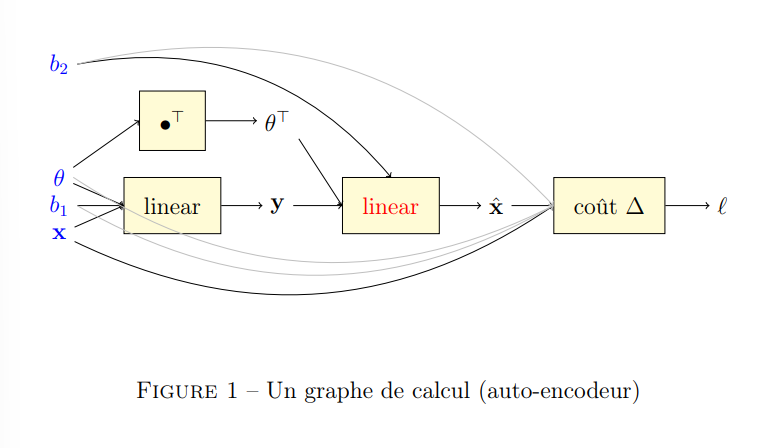

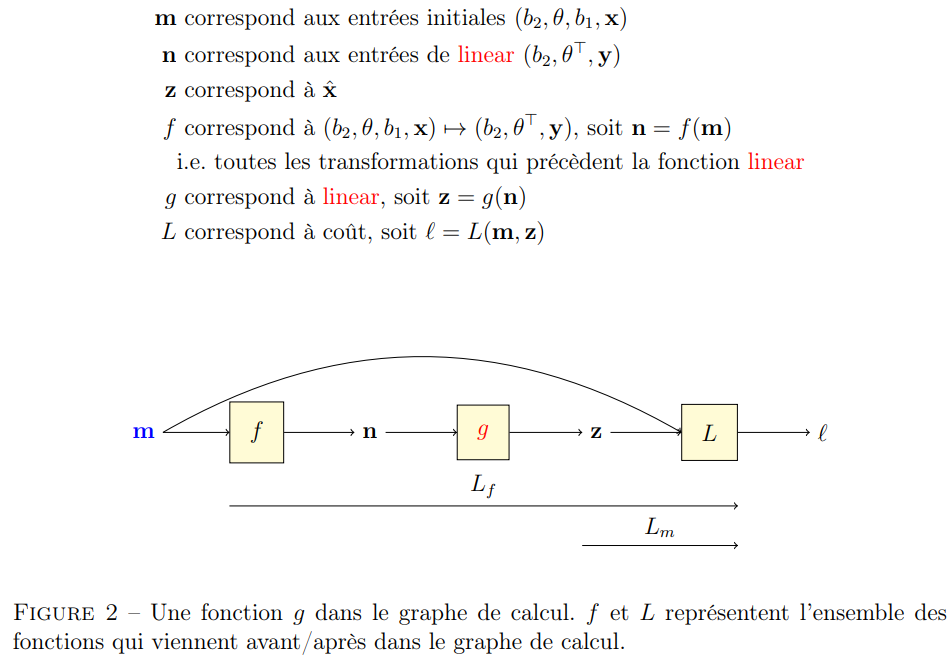

Afin de comprendre dans la pratique le mécanisme de rétro-propagation, nous nous concentrons sur la fonction $g$ (figure 2). Les entrée $\textbf{m}$ correspondent aux observations et à des paramètres, et $\textbf{n} = f(\textbf{m}), \textbf{z} = g(\textbf{n}) = g \circ f(\textbf{m})$ . On note par ailleurs $L_m(\textbf{z}) = L(\textbf{m},\textbf{z})$.

On rappelle que quand pour une fonciton $L(\textbf{u},\textbf{v}$ et des fonctions $g(t), h(t)$, les dérivées partielles composées de $L(g(t), h(t))$ sont:


$$\frac{\partial L}{\partial t_k}\left(g\left(t\right),h\left(t\right)\right) = \sum_{i}{\frac{\partial L}{\partial u_i}\left(g\left(t\right)\right)}\times\frac{\partial g_i}{\partial t_k}\left(t\right)+\sum_{j}{\frac{\partial L}{\partial v_j}\left(h\left(t\right)\right)}\times\frac{\partial h_j}{\partial t_k}\left(t\right)$$

On suppose que l'on connait $\frac{\partial{L}}{\partial{u_k}}$ et $\frac{\partial{L}}{\partial{v_k}}$. En utilisant le théorème de dérivaiton des fonctions composées, nous avons:
$$\frac{\partial L_f}{\partial m_k}\left(m\right)=\frac{\partial L}{\partial m_k}\left(m,z\right)+\sum_{i}{\frac{\partial L_m \circ g}{\partial n_i}\left(n\right)}\times\frac{\partial f_i}{\partial m_k}(m)$$

$$\frac{\partial L_m\circ g}{\partial n_k}\left(n\right)=\sum_{i}{\frac{\partial L_m}{\partial z_i}\left(z\right)}\times\frac{\partial g_i}{\partial n_k}\left(n\right)=\sum_{i}{\frac{\partial L}{\partial z_i}\left(m,z\right)}\times\frac{\partial g_i}{\partial n_k}\left(n\right)$$

En regardant les équations ci-dessus nous observons que pour calculer les dérivées partielles par rapport à l'ensemble des entrées $\frac{\partial L_f}{\partial m_k}\left(m\right)$, il suffit de remonter l'information depuis les fonctions filles vers leurs parentes et savoir calculer les dérivées partielles des fonctions par rapport à leurs entrées : $\frac{\partial f_i}{\partial m_k}(m)$, $\frac{\partial g_i}{\partial n_k}\left(n\right)$ que l'on peut calculer analytiquement.

En particulier, pour la fonction $g$ il suffit de connaitre $\frac{\partial L_m}{\partial z_i}$ (transmis par la fonciton $L$) et la forme analytique des dérivées partielles $\frac{\partial g_i}{\partial n_k}$ de $g$ par rapport à une de ses entrées.



**Autograd** (dans `PyTorch`) permet de faire cela de manière automatique en enregistrant les fonctions paretnes pour chaque calcul effectué.

### 2 Différenciation automatique : autograd

Commme vu au TP précédent, toute opération sous `PyTorch` hérite de la classe `torch.nn.Function` et doit définir
- une méthode `forward(context, *args)`: passe avant, calcule le résultat de la fonction appliquée aux arguments
- une méthode `backward(context, *args)`: passe arrière, calcule les dérivées partielles par rapport aux entrées. Les arguments de cette méthode correspondent aux valeurs des dérivées suivantes dans le graphe de calcul. En particulier, il y a autant d'arguments dans la méthode forward. Le calcul se fait sur les valeurs du dernier appel de forward.

En pratique, ce ne sont pas ces fonctions qui sont directement utilisées, mais un encapsulage de ces fonctions dans les tenseurs. A chaque fois qu'une opération est exécutée sur un tenseur, le graphe de calcul est calculé à la volée et stocké dans le tenseur résultat. La méthode `backward` d'un tenseur permet de rétropopager le calcul du gradient sur toutes les variables qui ont servies à son calcul; la valeur du gradient pour chaque dérivée partielle se trouve dans l'attribyt `grad` de la variable concernée.

Toutefois, comme le graphe de calcul est coûteux en ressource, il faut spécifier manuellement que l'on souhaite le calculer. Ceci est fait par l'intermédiaire de l'attribut booléen `requires_grad` des tenseurs (il suffit de le spécifier pour les variables racines pour que l'information soit propagée). De plus, les gradients intermédiaires ne sont pas conservés par défaut pour des raisons d'optimisation mémoire. Si on souhaite les conserver, il faut appeler la méthode `retain_grad()` sur la variable concernée.

Attention! vu les propriétés additives du gradient, l'appel à `backward()` met à jour par addition le gradient attaché à la variable. Il faut explicitement demander sa remise à zéro lors d'un nouveau calcul, sinon le résultat est additionné à l'ancien.

Par ailleurs, il est possible de spécifier que pour un bloc d'exécution donné le gradient n'aura pas à être calculer et ainsi désactiver le graphe de clacul grâce à l'instruction `with torch.no_grad()`



`a = torch.rand((1,10), requites_grad=True)`

`b = torch.rand((1,10), requites_grad=True)`

`c = a.mm(b.t())`

`d = 2 * c`

`c.retain_grad()` # on veut conserver le gradient par rapport à c

`d.backward()` # calcul du gradient et retropopagation jusqu'aux feuilles du graphe de calcul

`print(d.grad)` # Rien : le gradient par rapport à d n'est pas conservé

`print(c.grad)` ## celui ci est conservé

`print(a.grad)` ## gradient de d par rapport à a qui est une feuille

`print(b.grad)` ## gradient de d par rapport à b qui est une feuille

`d = 2 * a.mm(b.t())`

`d.backward()`

`print(a.grad)` ## 2 fois celui d'avant, le gradient est additionné

`a.grad.data.zero_()` ## reinitialisation du gradient pour a

`d = 2 * a.mm(b.t())`

`d.backward()`

`print(a.grad)` ## Cette fois c'est ok

`with torch.no_grad():`
>`c = a.mm(b.t())` # calcul est effectué sans garder le graphe de calcul

`c.backward()` ## erreur


Tests avec données de Boston Housing

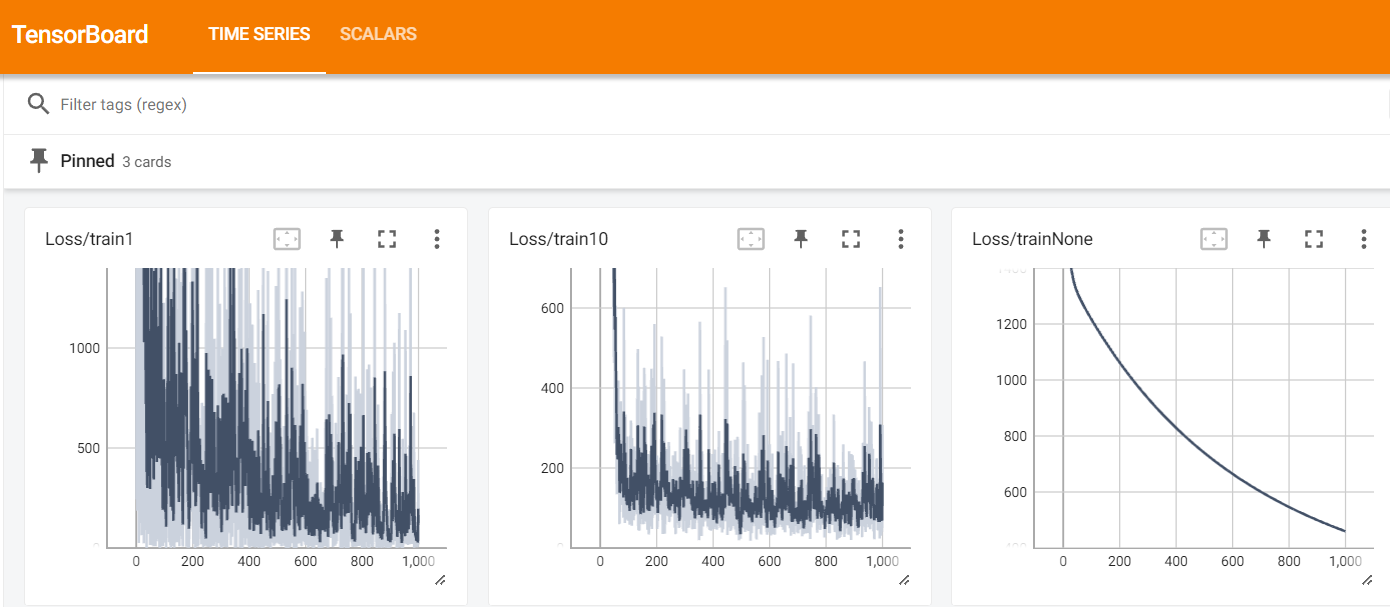

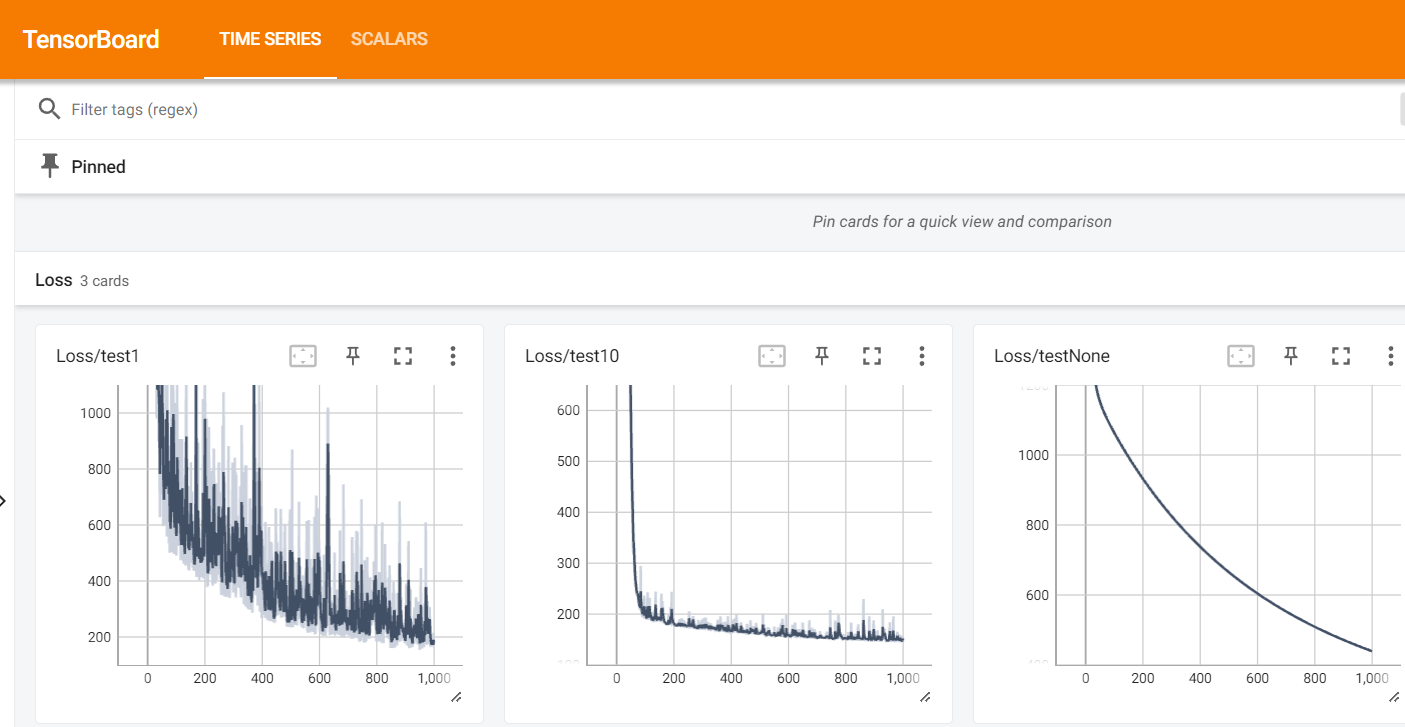

La descente de gradient en mini batch est la plus rapide à converger.

### 3 Optimiseur


`Pytorch` inclut une classe très utile pour la descente de gradient, `torch.optim` qui permet
- d'économiser quelques lignes de codes
- d'automatiser la màj des paramètres
- d'abstraire le type de descente de gradient utilisé
Une liste de paramètres à optimiser est passée à l'optimiseur lors de l'initialisation. La méthode `zero_grad()` permet de remettre le gradient à zéro et la méthode `step()` permet de faire une màj des param. 

L'exemple ci dessous permet de màj les param qu'une fois ttes les 100 itérations (mini batch de 100)

`w = torch.nn.Parameter(torch.randn(1,10))`

`b = torch.nn.Parameter(torch.randn(1))`

`optim = torch.optim.SGD(params = [w,b], lr = EPS)` # On optimise selon `w` et `b, lr`

`optim.zero.grad()`

Réinitialisation du gradient

`for i in range (NB_EPOCH)`

    loss = MSE(f(x,w,b),y) # Calcul du cout

    loss.backward() # Retropropagation

    if i % 100 = 0 : 

        optim.step() # Màj param w et b
        
        optim.zero_grad() # Reinitialisation du gradient

La classe `Parameter` est un wrapper de la classe `Tensor` qui permet entre autre de spécifier automatiquement que le gradient est requis pour ce tenseur et également de noter ce tenseur comme un paramètre à optimiser. Cette différenciation est utilisée esentiellement dans la classe `Module` afin de reconnaitre automatiquement les paramètres des autres entrées/constantes

### 4 Module

Dans le framework `Pytorch` le module est la brique de base qui permet de construire un réseau de neurones. Il permet de représenter en particulier:
- une couche du réseau (linéaire : `torch.nn.Linear`, convolution : `torch.nn.convXd`...)
- Une fonction d'activation (tanh : `torch.nn.Tanh`, sigmoide : `torch.nn.Sigmoid`, ReLu : `torch.nn.ReLu`)
- une fonction de cout (MSE : `torch.nn.MSELoss`, LA : `torch.nn.L1Loss`, CrossEntropy : `torch.nn.CrossEntropyLoss`)
- mais également des outils de régularisation (BatchNorm : `torch.nn.Batch.Norm1d`, Dropout : `torch.nn.Dropout`)
- un ensemble de modules : en termes info, un module est un conteneur abstrait qui peut contenir d'autres conteneurs: pls modules peuvent petre mis ensemble afin de former un nv module plus complexe.

Le fonctionnement est très proche des fonctions: un module encapsule en fait une fonction héritée de `torch.nn.Function` mais de manière à gérer automatiquement les paramètres à apprendre. La classe `Parameter` est utilisée pour créer un paramètre du module. Le paramètre ainsi créé est automatiquement ajouté à la liste des paramètres du module. La liste des paramètres est ensuite accessible par la méthode `parameters`. Tout comme une fonction, le modul est muni
- d'une méthode `forward` qui permet de calculer la sortie du module à partir des entrées
- d'une méthode `backward ` qui permet d'effectuer la rétropropagation (localement.)

Dans le cas où la méthode `forward` ne fait que des calculs à l'aide de fonctions disponibles sous `PyTorch` la méthode `backward` n'a pas besoin d'être implémentée!

En effet la rétropropagation peut être gérée par la différenciation automatique
